In [2]:
from classification import diversity_barchart, diversity_dotplot, \
                            plot_intermediate_characteristics, \
                            diversity_colors, glut_curves, calcium_response_classification
import cfg
from ip3_ca_ode_cfg import *
from falloff import capture_c, report_max_ratios, get_peaks
from spritz_diagram import run_spritz, evaluate_peaks, plot_spritz

import pickle
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as path_effects
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
import scipy.integrate
import os

import proplot as pplt

diversity_data_folder = 'data/ca_diversity/calibrated/'
diversity_fig_folder = 'figures/paper_plots/diversity/'
falloff_fig_folder = 'figures/paper_plots/falloff/'
spritz_fig_folder = 'figures/paper_plots/spritz/'
model_fig_folder = 'figures/paper_plots/modeling/'

save = 'figures/paper_plots2/'

pplt.rc.reset()
pplt.rc.update({
    'font.size': 10,
})

def color_cycle(cycle='default', idx=None):
    # Colors to assign to auxiliary tasks (they will be assigned in order)
    colors = pplt.Cycle(cycle).by_key()['color']
    hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255
    
    if idx is not None:
        return rgb_colors[idx]
    else:
        return rgb_colors
    
def generate_diversity_legend(ax, x_pos=-1, y_pos=-1):
    '''
    Generate the handles needed to create a legend with
    x_pos and y_pos place the markers so they can be
    outside of the axis
    '''
    lines = []
    for typ in diversity_colors:
        lines.append(ax.scatter([x_pos], [y_pos], c=diversity_colors[typ], 
                        label=typ, marker='s'))
    return lines

rgb_colors = color_cycle()

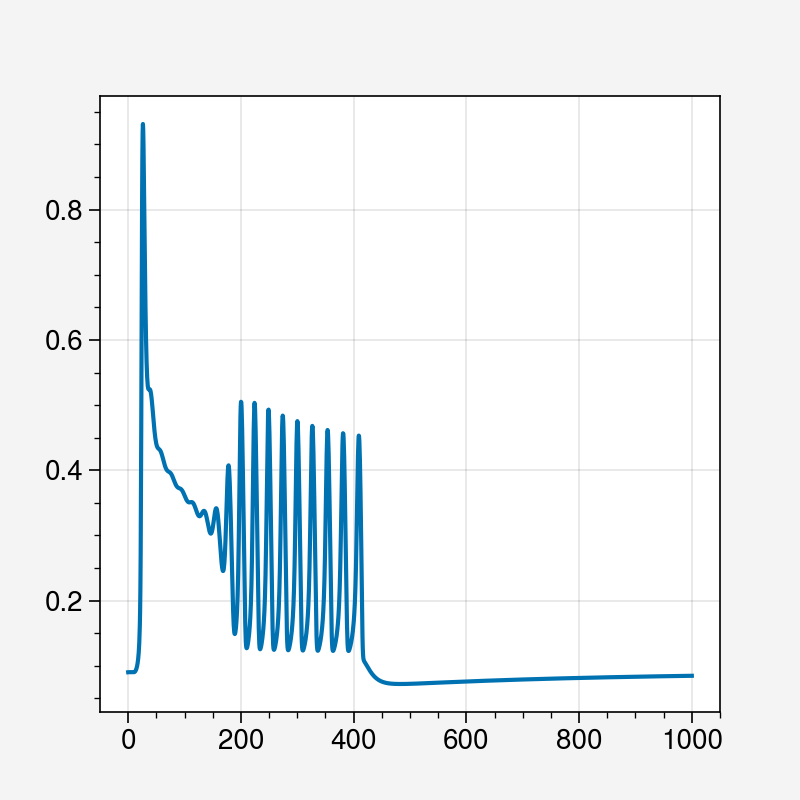

In [19]:
# Example experiment
cfg.input_duration = 400
cfg.input_max = 1.5
run_experiment('pulse')
plt.plot(cfg.t, cfg.c)

# Calcium Falloffs

## Plateau Falloffs

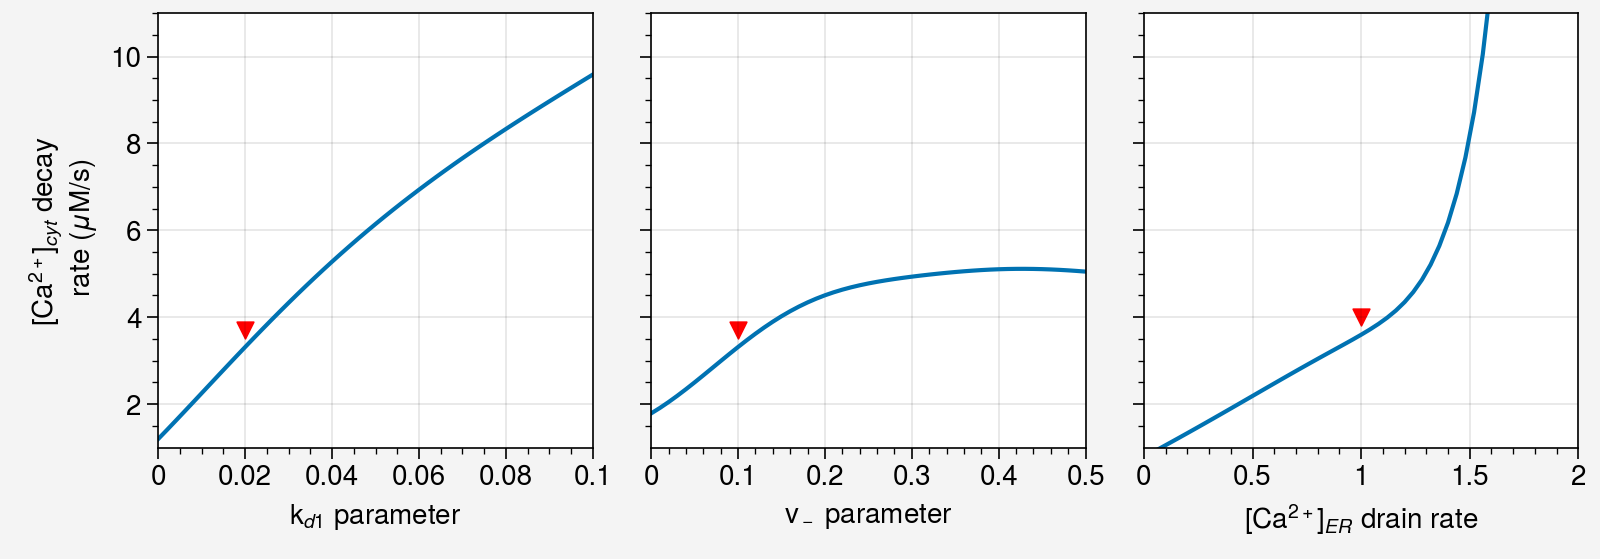

In [6]:
fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=8)

t1 = 65 - 50 + 30 #start - smoothing + partway through rampup time
t2 = t1 + 30 #30 seconds later

c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
c1s2, c2s2, _ = pickle.load(open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'rb'))

#ER storage drain rate
ratios = 1000*(np.array(c1s2) - np.array(c2s2)) / (t2 - t1)
x = np.linspace(0, 2, 51)
ax[2].plot(x, ratios)
# ax[2].plot([1, 1], [0, 12], c='black', alpha=0.3)
ax[2].scatter(x[25], ratios[25]+0.4, c='red', marker='v')

#kd1, v- parameters
ratios = 1000*(np.array(c1s['kd1']) - np.array(c2s['kd1'])) / (t2 - t1)
x = np.linspace(0, 5, 51) * 0.02 #multipliers times default kd1 parameters
ax[0].plot(x, ratios)
ax[0].scatter(x[10], ratios[10]+0.4, c='red', marker='v')


ratios = 1000*(np.array(c1s['v_3k']) - np.array(c2s['v_3k'])) / (t2 - t1)
x = np.linspace(0, 5, 51) * 0.1 #multipliers times default v_- parameters
ax[1].plot(x, ratios)
ax[1].scatter(x[10], ratios[10]+0.4, c='red', marker='v')

ax.format(ylabel='[Ca$^{2+}$]$_{cyt}$ decay\n rate ($\mu$M/s)',
          ylim=[1, 11])
ax[0].format(xlabel='k$_{d1}$ parameter')
ax[1].format(xlabel=r'v$_-$ parameter')
ax[2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')

fig.savefig(save+'1_1_plateau_falloffs')

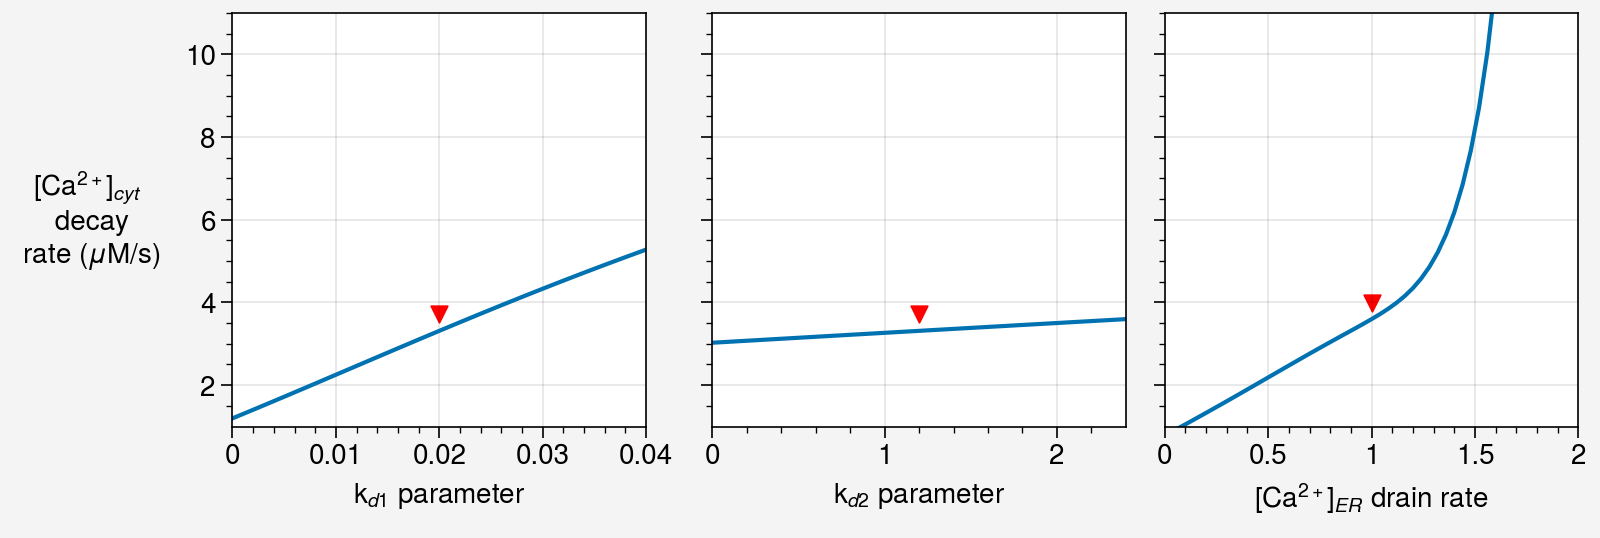

In [62]:
fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=8)

t1 = 65 - 50 + 30 #start - smoothing + partway through rampup time
t2 = t1 + 30 #30 seconds later

c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
c1s2, c2s2, _ = pickle.load(open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'rb'))

#ER storage drain rate
ratios = 1000*(np.array(c1s2) - np.array(c2s2)) / (t2 - t1)
x = np.linspace(0, 2, 51)
ax[2].plot(x, ratios)
# ax[2].plot([1, 1], [0, 12], c='black', alpha=0.3)
ax[2].scatter(x[25], ratios[25]+0.4, c='red', marker='v')

#kd1, v- parameters
ratios = 1000*(np.array(c1s['kd1']) - np.array(c2s['kd1'])) / (t2 - t1)
x = np.linspace(0, 2, 21) * 0.02 #multipliers times default kd1 parameters
ax[0].plot(x, ratios[:21])
ax[0].scatter(x[10], ratios[10]+0.4, c='red', marker='v')


ratios = 1000*(np.array(c1s['kd2']) - np.array(c2s['kd2'])) / (t2 - t1)
x = np.linspace(0, 2, 21) * 1.2 #multipliers times default kd2 parameters
ax[1].plot(x, ratios[:21])
ax[1].scatter(x[10], ratios[10]+0.4, c='red', marker='v')

ax.format(ylim=[1, 11])
ax[0].format(xlabel='k$_{d1}$ parameter')
ax[1].format(xlabel=r'k$_{d2}$ parameter')
ax[2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')
ax[0].set_ylabel('[Ca$^{2+}$]$_{cyt}$\n decay\n rate ($\mu$M/s)', ha='center',
                 va='center', rotation=0, labelpad=35)

fig.savefig(save+'1_1_plateau_falloffs')

## Oscillation Falloffs

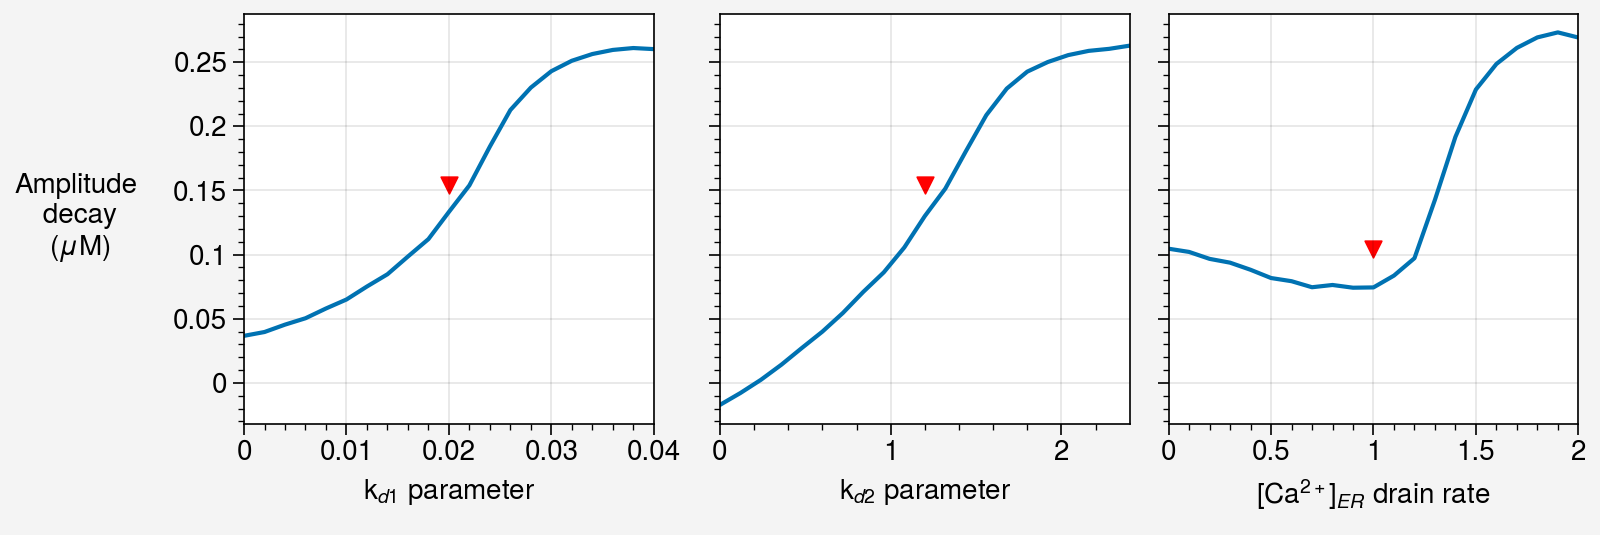

In [66]:
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
# default_vals = [0.1, 0.005, 0.02, 1.2]
default_vals = {
    'v_3k': 0.1,
    'v_delta': 0.005, 
    'kd1': 0.02,
    'kd2': 1.2,
}


# decays = pickle.load(open('data/plot_data/falloff/2.1_oscillation_var', 'rb'))
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.1_oscillation_falloffs', 'rb'))
# multipliers = np.linspace(0, 5, 51)
multipliers = np.linspace(0, 2, 21)

fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=8)

# Plot parameter effects
plot_vars = ['kd1', 'kd2']
plot_labels = ['kd1', 'kd2']
for i, var in enumerate(plot_vars):
    x = multipliers * default_vals[var]
    y = []
    for j in range(len(multipliers)):
        t_peaks = all_t_peaks[var][j]
        c_peaks = all_c_peaks[var][j]
        y.append(c_peaks[1] - c_peaks[-1])
    
    # ax[i].plot(x, y)
    ax[i].plot(x, pd.Series(y).ewm(alpha=0.5).mean())
    ax[i].scatter(multipliers[10]*default_vals[var], y[10],
                 c='red', marker='v')

# Plot ER depletion effect
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.2_er_oscillation_falloffs', 'rb'))
x = multipliers
y = []
for j in range(len(multipliers)):
    t_peaks = all_t_peaks[j]
    c_peaks = all_c_peaks[j]
    y.append(c_peaks[1] - c_peaks[-1])
# ax[2].plot(x, y)
ax[2].plot(x, pd.Series(y).ewm(alpha=0.5).mean())
ax[2].scatter(multipliers[10], y[10]+0.03, c='red', marker='v')
    
ax[0].format(xlabel=r'k$_{d1}$ parameter')
ax[1].format(xlabel=r'k$_{d2}$ parameter')
ax[2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')
ax[0].set_ylabel('Amplitude\n decay\n ($\mu$M)', rotation=0, 
                 ha='center', va='center', labelpad=35)

fig.savefig(save + '1_2_oscillation_falloffs')

## Example responses

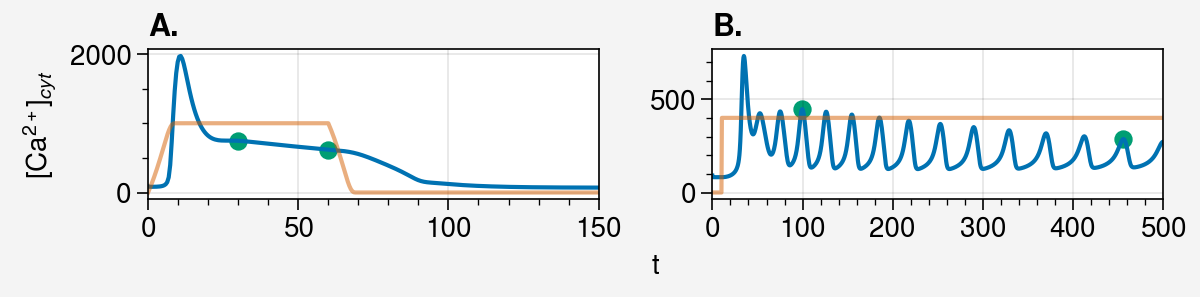

In [88]:
fig, ax = pplt.subplots(ncols=2, refaspect=3, figwidth=6, sharex=False, 
                        sharey=False, spanx=True)

set_init('c_t')
cfg.input_max = 20
cfg.input_start = 10
cfg.input_duration = 50
cfg.input_smoothing = 10
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30

run_experiment('exponential_pulse', t_f=150, max_step=0.5)
ax[0].plot(cfg.t, cfg.c*1000)
ax[0].plot(cfg.t_input, cfg.glut * 50, alpha=0.5)
ax[0].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

cfg.input_start = 10
cfg.input_max = 0.8
cfg.input_duration = 1000

run_experiment('pulse', t_f=500, max_step=0.5)
t_peaks, c_peaks = get_peaks()

ax[1].plot(cfg.t, cfg.c*1000)
ax[1].plot(cfg.t_input, cfg.glut * 500, alpha=0.5)
# ax[1].scatter(t_peaks[1:], c_peaks[1:]*1000)
ax[1].scatter([t_peaks[np.argmax(c_peaks[1:])+1], t_peaks[-1]],
               [np.max(c_peaks[1:])*1000, c_peaks[-1]*1000])

ax[0].set_ylabel(c_label)
ax.format(abc='A.', xlabel='t')
# fig.text(0.55, 0.06, 't')

fig.savefig(save + '1_3_example_decay_experiments')

### Example ER depletion

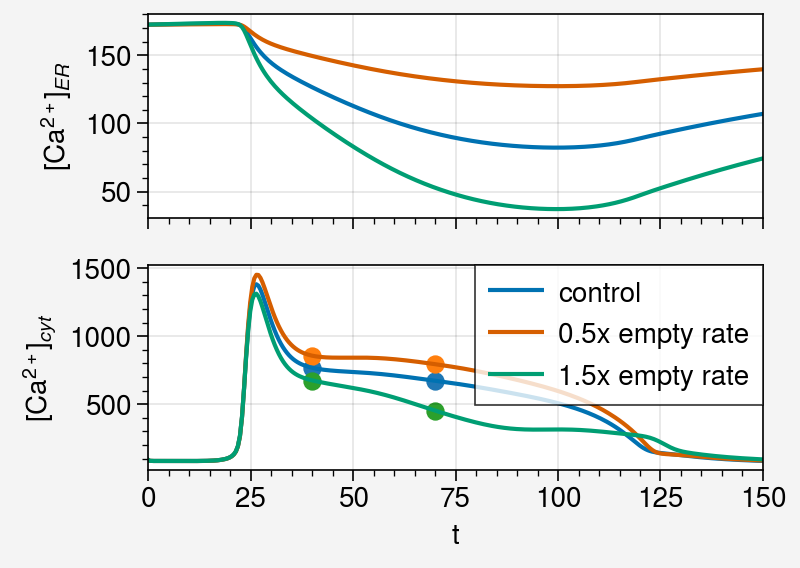

In [119]:
cfg.input_max = 20
cfg.input_start = 10
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


fig, ax = pplt.subplots(nrows=2, refaspect=3, figwidth=4, sharey=False)

run_experiment('exponential_pulse', t_f=150, max_step=0.5)
fix_c_er = cfg.c_er
cfg.c = cfg.c*1000
ax[0].plot(cfg.t, cfg.c_er, label='control')
ax[1].plot(cfg.t, cfg.c, label='control')
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)], c=rgb_colors[0])

mult = 0.5
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=150, max_step=0.5, fix_c_er_func=inter)
cfg.c = cfg.c*1000
ax[0].plot(cfg.t, cfg.c_er, label='0.5x empty rate')
ax[1].plot(cfg.t, cfg.c, label='0.5x empty rate')
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)], c=rgb_colors[1])

mult = 1.5
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=150, max_step=0.5, fix_c_er_func=inter)
cfg.c = cfg.c*1000
ax[0].plot(cfg.t, cfg.c_er, label='1.5x empty rate')
ax[1].plot(cfg.t, cfg.c, label='1.5x empty rate')
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)], c=rgb_colors[2])

ax[1].legend(ncols=1)
# ax[0].legend(bbox_to_anchor=(1, 1, 0, 0))

ax[0].format(ylabel=c_er_label)
ax[1].format(ylabel=c_label, xlabel='t')

plt.savefig(save + '1_3_2_depletion_example', bbox_inches='tight')

## Combined

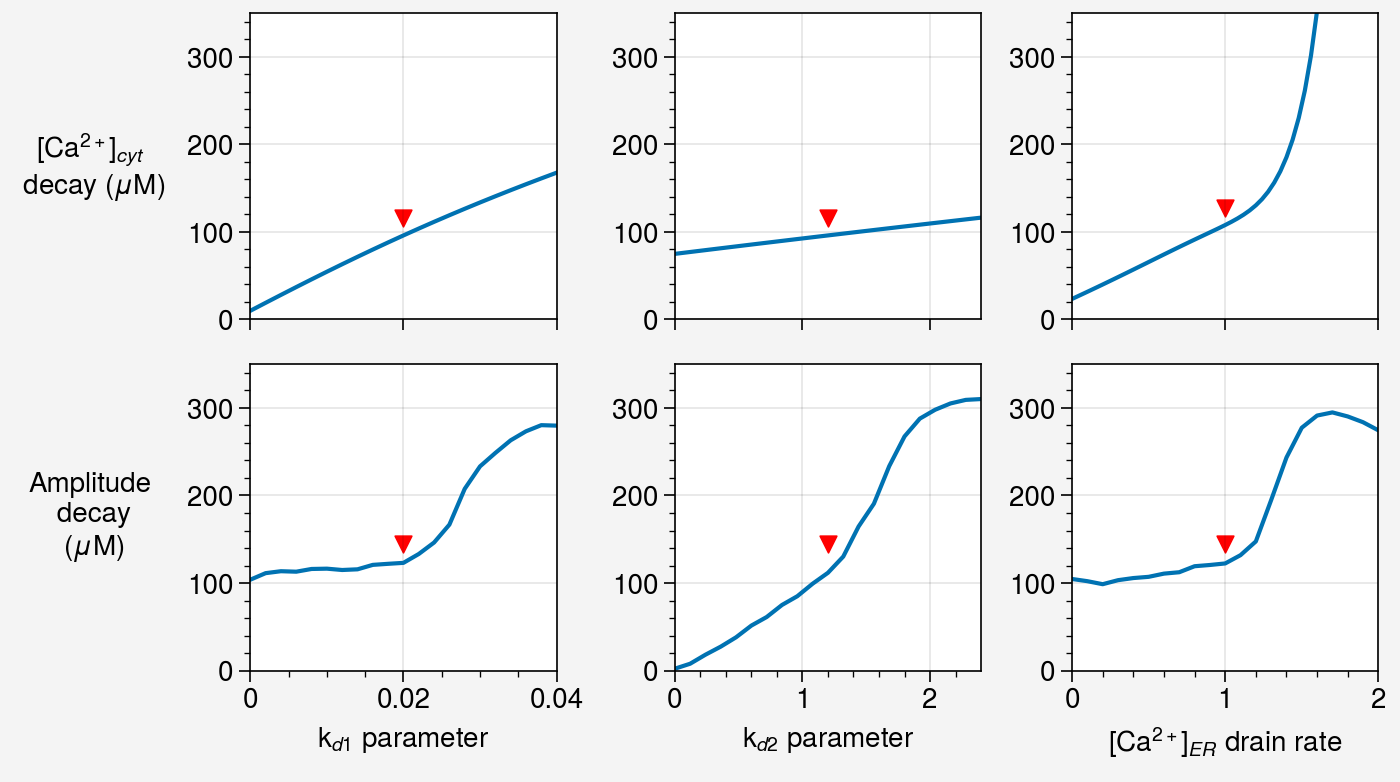

In [97]:
fig, ax = pplt.subplots(ncols=3, nrows=2, sharex=False, 
                        sharey=False, figwidth=7)

'''Plateau'''
t1 = 65 - 50 + 30 #start - smoothing + partway through rampup time
t2 = t1 + 30 #30 seconds later

# c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate_fixedcer', 'rb'))
c1s2, c2s2, _ = pickle.load(open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'rb'))

#ER storage drain rate
# ratios = 1000*(np.array(c1s2) - np.array(c2s2)) / (t2 - t1)
ratios = 1000*(np.array(c1s2) - np.array(c2s2))
x = np.linspace(0, 2, 51)
ax[0, 2].plot(x, ratios)
# ax[2].plot([1, 1], [0, 12], c='black', alpha=0.3)
ax[0,2].scatter(x[25], ratios[25]+20, c='red', marker='v')

#kd1, v- parameters
# ratios = 1000*(np.array(c1s['kd1']) - np.array(c2s['kd1'])) / (t2 - t1)
ratios = 1000*(np.array(c1s['kd1']) - np.array(c2s['kd1']))
x = np.linspace(0, 2, 21) * 0.02 #multipliers times default kd1 parameters
ax[0, 0].plot(x, ratios[:21])
ax[0, 0].scatter(x[10], ratios[10]+20, c='red', marker='v')


# ratios = 1000*(np.array(c1s['kd2']) - np.array(c2s['kd2'])) / (t2 - t1)
ratios = 1000*(np.array(c1s['kd2']) - np.array(c2s['kd2']))
x = np.linspace(0, 2, 21) * 1.2 #multipliers times default kd2 parameters
ax[0,1].plot(x, ratios[:21])
ax[0,1].scatter(x[10], ratios[10]+20, c='red', marker='v')

ax[0,:].format(ylim=[0, 350])
ax[0,0].format(xlabel='k$_{d1}$ parameter')
ax[0,1].format(xlabel=r'k$_{d2}$ parameter')
ax[0,2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')
ax[0,0].set_ylabel('[Ca$^{2+}$]$_{cyt}$\n decay ($\mu$M)', ha='center',
                 va='center', rotation=0, labelpad=35)



'''Oscillation'''
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
# default_vals = [0.1, 0.005, 0.02, 1.2]
default_vals = {
    'v_3k': 0.1,
    'v_delta': 0.005, 
    'kd1': 0.02,
    'kd2': 1.2,
}


# decays = pickle.load(open('data/plot_data/falloff/2.1_oscillation_var', 'rb'))
# all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.1_oscillation_falloffs', 'rb'))
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.1_oscillation_falloffs_fixedcer', 'rb'))
# multipliers = np.linspace(0, 5, 51)
multipliers = np.linspace(0, 2, 21)

# Plot parameter effects
plot_vars = ['kd1', 'kd2']
plot_labels = ['kd1', 'kd2']
for i, var in enumerate(plot_vars):
    x = multipliers * default_vals[var]
    y = []
    for j in range(len(multipliers)):
        t_peaks = all_t_peaks[var][j]
        c_peaks = all_c_peaks[var][j]
        y.append((np.max(c_peaks[1:]) - c_peaks[-1]) * 1000)
    
    # ax[i].plot(x, y)
    ax[1,i].plot(x, pd.Series(y).ewm(alpha=0.5).mean())
    ax[1,i].scatter(multipliers[10]*default_vals[var], y[10]+20,
                 c='red', marker='v')

# Plot ER depletion effect
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.2_er_oscillation_falloffs', 'rb'))
x = multipliers
y = []
for j in range(len(multipliers)):
    t_peaks = all_t_peaks[j]
    c_peaks = all_c_peaks[j]
    y.append((np.max(c_peaks[1:]) - c_peaks[-1]) * 1000)
# ax[2].plot(x, y)
ax[1,2].plot(x, pd.Series(y).ewm(alpha=0.5).mean())
ax[1,2].scatter(multipliers[10], y[10]+20, c='red', marker='v')
    
ax[1,0].format(xlabel=r'k$_{d1}$ parameter')
ax[1,1].format(xlabel=r'k$_{d2}$ parameter')
ax[1,2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')
ax[1,0].set_ylabel('Amplitude\n decay\n ($\mu$M)', rotation=0, 
                 ha='center', va='center', labelpad=35)
ax[1,:].format(ylim=[0, 350])
ax[0,:].format(xticklabels=[], xlabel='')

fig.savefig(save + '1_4_falloff_combined')


# GPCR Modeling

## Double bath calibrations

In [7]:
'''
Double bath data collection for rest time summary subplot
'''

# first_ons = np.arange(10, 620, 100)
first = 240
# gluts = np.arange(0.1, 1, 0.2)
glut = 20
slider = [0, 0.5, 1]
rests = np.arange(10, 620, 20)
cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4), sharey=True)
kd1 = cfg.kd1
kd2 = cfg.kd2
for i, mod in enumerate(tqdm(slider)):
    ratios = []
    color = cmap(mod) if mod != 0.5 else 'k'
    
    cfg.kd1 = kd1 * mod
    cfg.kd2 = kd2 * (1 - mod)
    for rest in rests:

        experiment_name = 'bath_{}_rest_{}_mod_{}'.format(first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
#             if not experiment_name in os.listdir('data/experiments/double_bath'):

        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_vals = [0, glut, 0, glut, 0]

        sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
        save_experiment(file_name, verbose=False)

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)


cfg.kd1 = kd1
cfg.kd2 = kd2


'''Convert into compiled plot data'''
rests = np.arange(10, 620, 20)
first = 240
# labels = ['Gd1 \']
slider = [0, 1]

data = {'rests': rests}

for i, mod in enumerate(slider):
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for rest in rests:
        experiment_name = 'bath_{}_rest_{}_mod_{}'.format(first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
        
    if mod == 1:
        data['kd1'] = ratios
    else:
        data['kd2'] = ratios

pickle.dump(data, open('data/plot_data/gpcr/1_double_bath_rest', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:24<00:00, 28.30s/it]


In [11]:
'''
Double bath data collection for rest time summary subplot
'''

# first_ons = np.arange(10, 620, 100)
first = 240
# gluts = np.arange(0.1, 1, 0.2)
glut = 20

desense_values = [(0.02, 0), 
                  (0.02, 1.2),
                  (0, 1.2)]

rests = np.arange(10, 620, 20)
cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4), sharey=True)
kd1 = cfg.kd1
kd2 = cfg.kd2
for i, desense in enumerate(tqdm(desense_values)):
    ratios = []
    # color = cmap(mod) if mod != 0.5 else 'k'
    
    cfg.kd1 = desense[0]
    cfg.kd2 = desense[1]
    for rest in rests:

        experiment_name = f'bath_{first}_rest_{rest}_kd1{desense[0]}_kd2{desense[1]}'
        file_name = 'double_bath/' + experiment_name
        if not experiment_name in os.listdir('data/experiments/double_bath'):

            ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
            cfg.custom_input_vals = [0, glut, 0, glut, 0]

            sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
            save_experiment(file_name, verbose=False)

            ratio, _, _ = report_max_ratios(times=ratio_times)
            ratios.append(ratio)


cfg.kd1 = kd1
cfg.kd2 = kd2


'''Convert into compiled plot data'''
rests = np.arange(10, 620, 20)
first = 240
# labels = ['Gd1 \']

data = {'rests': rests}

for i, desense in enumerate(desense_values):
    # color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for rest in rests:
        experiment_name = f'bath_{first}_rest_{rest}_kd1{desense[0]}_kd2{desense[1]}'
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
        
    data[f'kd1{desense[0]}_kd2{desense[1]}'] = ratios
pickle.dump(data, open('data/plot_data/gpcr/1b_double_bath_with_mixed', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 54.66it/s]


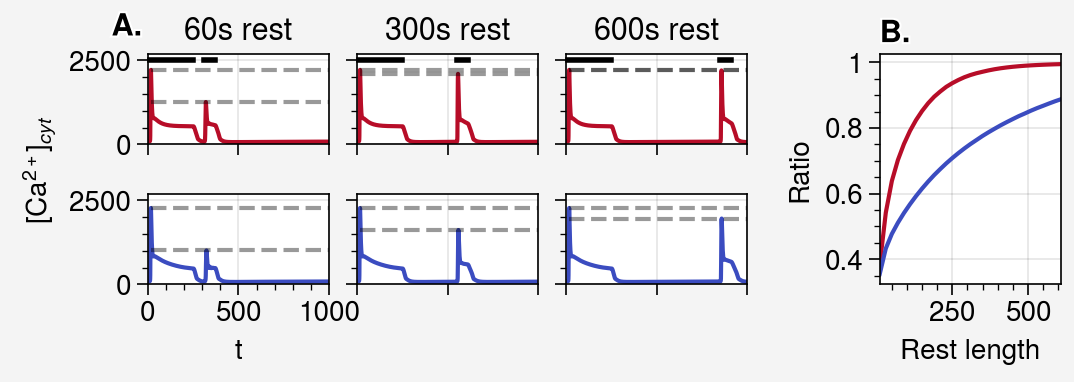

In [13]:
array = [
    [1, 1, 2, 2, 3, 3, 0, 7, 7],
    [4, 4, 5, 5, 6, 6, 0, 7, 7]
]

rests = [60, 300, 600]
cfg.custom_input_vals = [0, 20, 0, 20, 0]
first = 240
kd1 = 0.02
kd2 = 1.2
set_init('default')

cmap = matplotlib.cm.get_cmap('coolwarm')
blue = cmap(0)
red = cmap(0.99)

fig, ax = pplt.subplots(array, refaspect=2, figwidth=6, sharex=False,
                       wspace=1)

# Plot double baths
for i, rest in enumerate(rests):
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    cfg.custom_input_times = [0] + ratio_times
    
    # kd1 only
    cfg.kd1 = kd1
    cfg.kd2 = 0
    run_experiment('custom', t_f=1000, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[i].plot(cfg.t, cfg.c * 1000, c=red)
    ax[i].plot([cfg.t[pos[0]], 1000], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[i].plot([cfg.t[pos[0]], 1000], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)

    # Plot bath indicators
    ax[i].plot([ratio_times[0], ratio_times[1]], [2500, 2500], 'k', linewidth=2, clip_on=False)
    ax[i].plot([ratio_times[2], ratio_times[3]], [2500, 2500], 'k', linewidth=2, clip_on=False)

    
    # kd2 only
    cfg.kd1 = 0
    cfg.kd2 = kd2
    run_experiment('custom', t_f=1000, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[3+i].plot(cfg.t, cfg.c * 1000, c=blue)
    ax[3+i].plot([cfg.t[pos[0]], 1000], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[3+i].plot([cfg.t[pos[0]], 1000], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    

add_abc_to_subaxes(ax[0], left=-0.2, top=1.2)
add_abc_to_subaxes(ax[6], 'B.')

data = pickle.load(open('data/plot_data/gpcr/1_double_bath_rest', 'rb'))
ax[6].plot(data['rests'], data['kd1'], c=red)
ax[6].plot(data['rests'], data['kd2'], c=blue)

ax[:6].format(xlabel='t', ylabel='[Ca$^{2+}$]$_{cyt}$', ylim=[0, 2700])
ax[6].format(xlabel='Rest length', ylabel='Ratio')
ax[:3].format(xticklabels=[], xlabel='', 
             title=['60s rest', '300s rest', '600s rest'])
ax[4:6].format(xticklabels=[], xlabel='')

fig.savefig(save + '2_1_gpcr_double_baths')

cfg.kd1 = kd1
cfg.kd2 = kd2

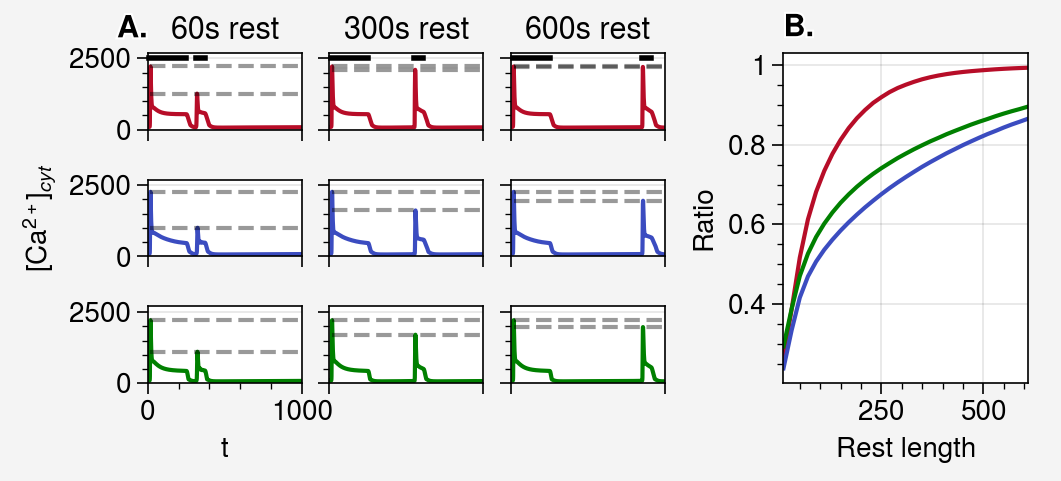

In [3]:
array = [
    [1, 1, 2, 2, 3, 3, 0, 10, 10, 10],
    [4, 4, 5, 5, 6, 6, 0, 10, 10, 10],
    [7, 7, 8, 8, 9, 9, 0, 10, 10, 10]
]

rests = [60, 300, 600]
cfg.custom_input_vals = [0, 20, 0, 20, 0]
first = 240
kd1 = 0.02
kd2 = 1.2
set_init('default')

cmap = matplotlib.cm.get_cmap('coolwarm')
blue = cmap(0)
red = cmap(0.99)

fig, ax = pplt.subplots(array, refaspect=2, figwidth=6, sharex=False,
                       wspace=1)

# Plot double baths
for i, rest in enumerate(rests):
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    cfg.custom_input_times = [0] + ratio_times
    
    # kd1 only
    cfg.kd1 = kd1
    cfg.kd2 = 0
    run_experiment('custom', t_f=1000, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[i].plot(cfg.t, cfg.c * 1000, c=red)
    ax[i].plot([cfg.t[pos[0]], 1000], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[i].plot([cfg.t[pos[0]], 1000], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)

    # Plot bath indicators
    ax[i].plot([ratio_times[0], ratio_times[1]], [2500, 2500], 'k', linewidth=2, clip_on=False)
    ax[i].plot([ratio_times[2], ratio_times[3]], [2500, 2500], 'k', linewidth=2, clip_on=False)

    
    # kd2 only
    cfg.kd1 = 0
    cfg.kd2 = kd2
    run_experiment('custom', t_f=1000, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[3+i].plot(cfg.t, cfg.c * 1000, c=blue)
    ax[3+i].plot([cfg.t[pos[0]], 1000], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[3+i].plot([cfg.t[pos[0]], 1000], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    # kd1+kd2
    cfg.kd1 = kd1
    cfg.kd2 = kd2
    run_experiment('custom', t_f=1000, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[6+i].plot(cfg.t, cfg.c * 1000, c='green')
    ax[6+i].plot([cfg.t[pos[0]], 1000], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[6+i].plot([cfg.t[pos[0]], 1000], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    

add_abc_to_subaxes(ax[0], left=-0.2, top=1.2)
add_abc_to_subaxes(ax[9], 'B.')

data = pickle.load(open('data/plot_data/gpcr/1b_double_bath_with_mixed', 'rb'))
ax[9].plot(data['rests'], data['kd10.02_kd20'], c=red)
ax[9].plot(data['rests'], data['kd10_kd21.2'], c=blue)
ax[9].plot(data['rests'], data['kd10.02_kd21.2'], c='green')

ax[:9].format(xlabel='t', ylabel='[Ca$^{2+}$]$_{cyt}$', ylim=[0, 2700])
ax[9].format(xlabel='Rest length', ylabel='Ratio')
ax[:3].format(title=['60s rest', '300s rest', '600s rest'])
ax[:6].format(xticklabels=[], xlabel='')
ax[7:9].format(xticklabels=[], xlabel='')

fig.savefig(save + '2_1b_gpcr_double_baths')

cfg.kd1 = kd1
cfg.kd2 = kd2

## Example simulation time courses

### Double bath GPCR

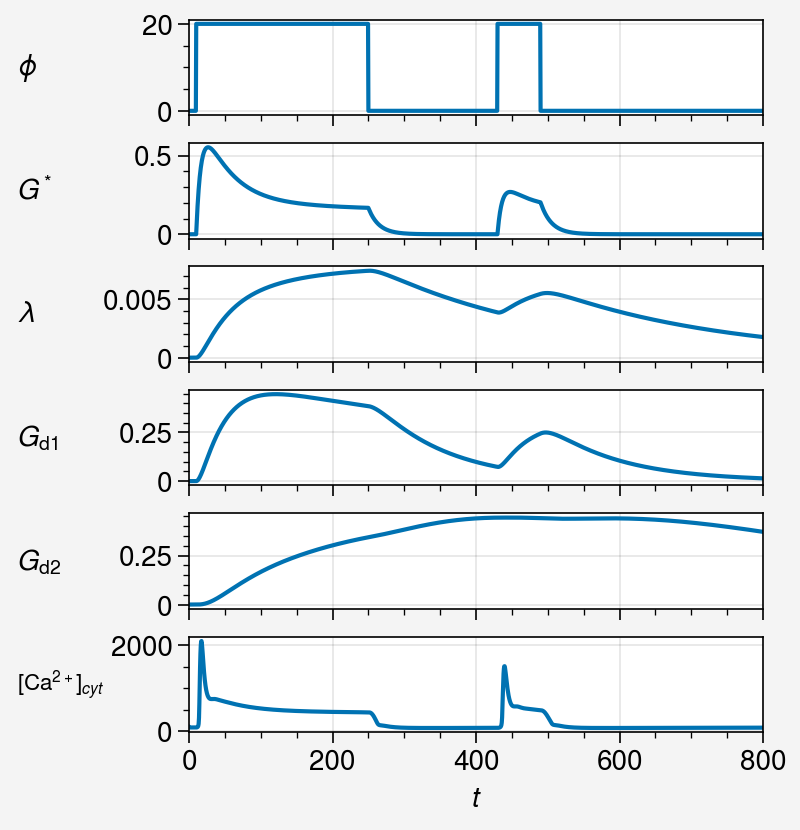

In [82]:
fig, ax = pplt.subplots(nrows=6, figwidth=4, refaspect=6, hspace=1, sharey=False)

first = 240
rest = 180
ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
cfg.custom_input_times = [0] + ratio_times
cfg.custom_input_vals = [0, 20, 0, 20, 0]

# Stepped oscillatory response
set_init('c_t')
cfg.input_max = 0.7
cfg.input_duration = 500
run_experiment('custom', t_f=800, max_step=0.5)
# plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax, add_ylabels=False)
plot_experiment_plots(['glut', 'Gstar', 'lamb', 'Gd1', 'Gd2', 'c'], axs=ax, add_ylabels=True,
                     ylabel_padding=[-0.3, 0.5], remove_xticks=False)

ax[5].set_ylabel(c_label, fontsize=8, ha='left')

fig.savefig(save + '2_2_1_double_bath_gpcr')

### Example step stimulation

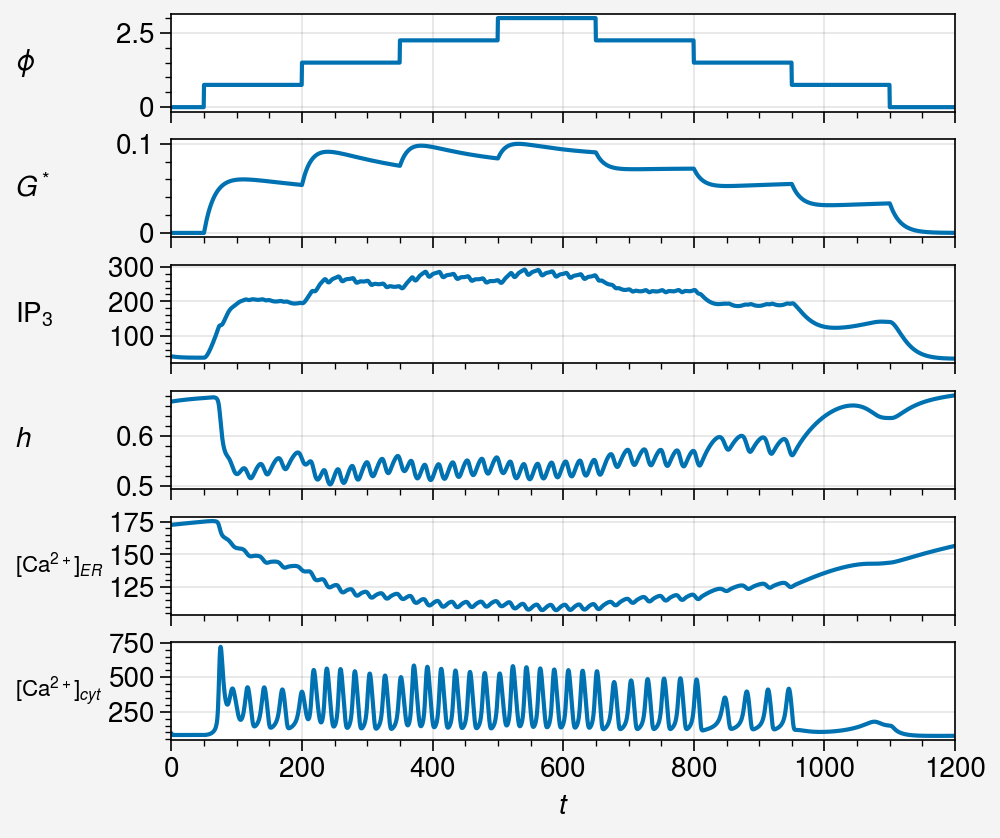

In [83]:
fig, ax = pplt.subplots(nrows=6, figwidth=5, refaspect=8, hspace=1, sharey=False)

# Stepped oscillatory response
set_init('c_t')
cfg.step_max_value = 3
run_experiment('step', t_f=1200, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax, add_ylabels=True,
                      ylabel_padding=[-0.2, 0.5], remove_xticks=False)

ax[4].set_ylabel(c_er_label, fontsize=8, ha='left')
ax[5].set_ylabel(c_label, fontsize=8, ha='left')

fig.savefig(save + '2_2_2_step_stimulation')


### Oscillation with v_3k at original levels

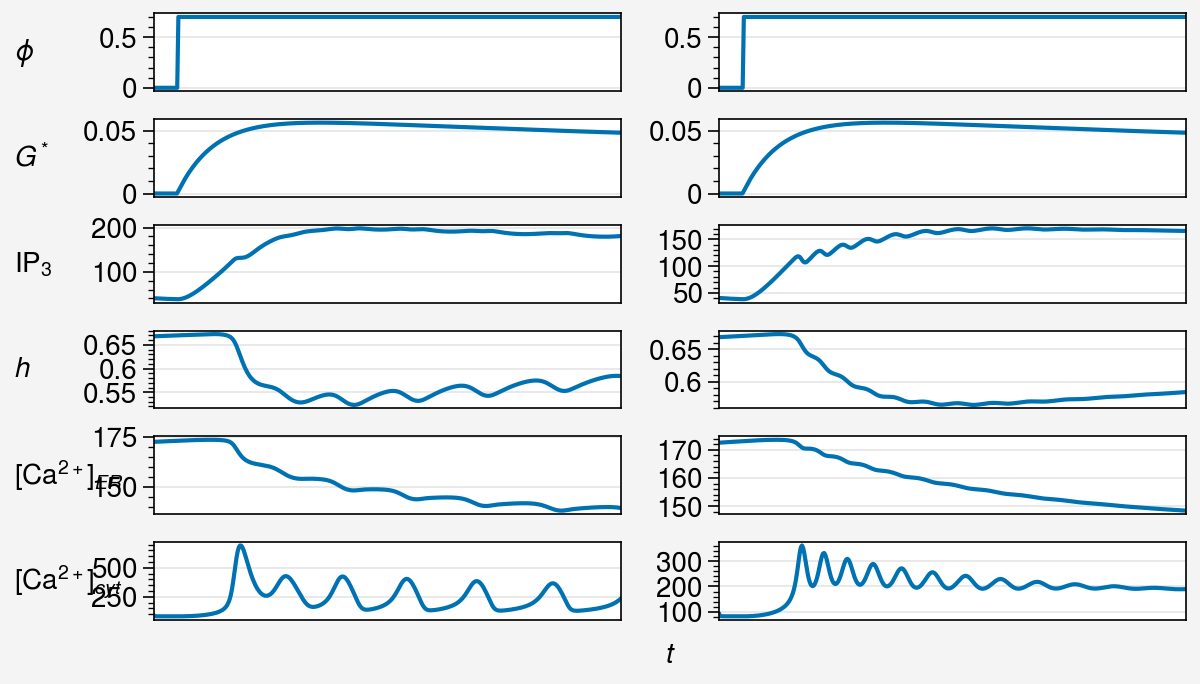

In [78]:
fig, ax = pplt.subplots(nrows=6, ncols=2, figwidth=6, refaspect=6, hspace=1, sharey=False)

# Stepped oscillatory response
set_init('c_t')
cfg.input_max = 0.7
cfg.input_duration = 500
run_experiment('pulse', t_f=200, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 0], add_ylabels=True,
                     ylabel_padding=[-0.3, 0.5])


cfg.v_3k = 2.0
set_init('c_t')
cfg.input_max = 0.7
cfg.input_duration = 500
run_experiment('pulse', t_f=200, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 1], add_ylabels=False)

cfg.v_3k = 0.1

fig.savefig(save + '2_2_3_v3k_oscillation')

# Oscillation Delays

**Required functions (run the below block to load functions)**

In [8]:
def test_oscillation_delay_t(init=None, input_max=0.8, max_step=2):
    cfg.input_duration = 200
    cfg.input_max = input_max
    cfg.input_start = 0
    if init != None:
        cfg.all_init = init.copy()
    
    run_experiment('pulse', t_f=200, max_step=max_step)

    peaks = scipy.signal.find_peaks(cfg.c)[0]
    peaks = peaks[peaks > 10]
    first_peak = peaks[0]
    second_peak = peaks[1]
    troughs = scipy.signal.find_peaks(-cfg.c)[0]
    troughs = troughs[troughs > 10]
    first_trough = troughs[0]
    
    c_diff = cfg.c[second_peak] - cfg.c[first_trough]
    c_diff2 = cfg.c[peaks[2]] - cfg.c[troughs[1]]
    
    
    if (cfg.c[first_peak:] > 0.2).all():
        t_to_low_enough = cfg.t[-1]
        idx_to_low_enough = -1
        
    else:
        steps_to_02 = (cfg.c[first_peak:] < 0.2).argmax()
        t_to_low_enough = cfg.t[first_peak+steps_to_02]
        idx_to_low_enough = first_peak + steps_to_02
        
    return t_to_low_enough, idx_to_low_enough, c_diff, c_diff2


'''Poisson train input functions'''

def next_time(rate):
    return -math.log(1 - random.random()) / rate

def generate_train(rate, t_f=300):
    total_time = 0
    spikes = []
    while True:
        nxt = next_time(rate)
        total_time += nxt
        if total_time > t_f:
            return np.array(spikes)
        spikes.append(total_time)
    
    
def exponential_input(t):
    '''
    This function will generate an exponential increase and decay glutamate input
    '''
    input_half = cfg.input_duration / 2
    if(t > cfg.input_start and t <= (cfg.input_start + input_half)):
        return cfg.input_max * (1 - np.exp((t - cfg.input_start) / (t - cfg.input_start - input_half)))
    elif(t > (cfg.input_start + input_half) and t <= (cfg.input_start + cfg.input_duration)):
        return cfg.input_max * np.exp((t - cfg.input_start - input_half) / (t - cfg.input_start - cfg.input_duration))
    else:
        return cfg.input_min
    
    
def exponential_train(t):
    '''
    Get exponential input based on a Poisson spike train
    '''
    if t > np.max(cfg.train):
        idx = len(cfg.train) - 1
    else:
        idx = np.argmax(cfg.train > t) - 1
        if idx < 0:
            return cfg.input_min
#     print(idx)
    t = t - cfg.train[idx]
    return exponential_input(t)
    
def copy_init():
    cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1],
                    cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]

## h, c_tot initial condition effects

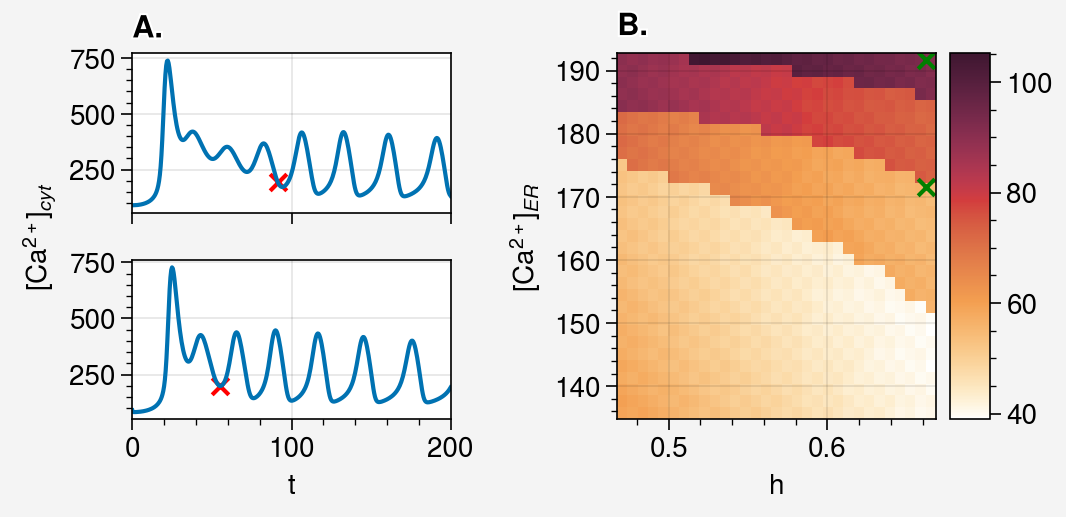

In [31]:
array = [
    [1, 1, 3, 3],
    [2, 2, 3, 3]
]

fig, ax = pplt.subplots(array, refaspect=2, wspace=6, sharex=False, figwidth=7)


set_init('default')
t_first, first, c_diff, c_diff2 = test_oscillation_delay_t(max_step=0.5)
ax[0].plot(cfg.t, cfg.c*1000)
ax[0].scatter([cfg.t[first]], [cfg.c[first]*1000], marker='x', c='red')

set_init('c_t')
t_first, first, c_diff, c_diff2 = test_oscillation_delay_t(max_step=0.5)
ax[1].plot(cfg.t, cfg.c*1000)
ax[1].scatter([cfg.t[first]], [cfg.c[first]*1000], marker='x', c='red')

shaped_z, extent = pickle.load(open('data/plot_data/oscillation_delay/1_h_ct_delays', 'rb'))
c_init = 0.0913785
extent2 = (extent[0], extent[1], (extent[2] - c_init) * gamma, (extent[3] - c_init) * gamma)
cm = ax[2].imshow(shaped_z, extent=extent2, aspect='auto')
# Plot initial conditions
set_init('default')
ax[2].scatter([cfg.all_init[2]-0.006], [(cfg.all_init[1] - c_init)*gamma-1.], c='green', marker='x')
set_init('c_t')
ax[2].scatter([cfg.all_init[2]-0.006], [(cfg.all_init[1] - c_init)*gamma-1.], c='green', marker='x')

ax[:2].format(xlabel='t', ylabel=c_label)
ax[2].format(xlabel='h', ylabel=c_er_label)
ax[0].format(xlabel='', xticklabels=[])
ax[2].colorbar(cm)

add_abc_to_subaxes(ax[0], top=1.1)
add_abc_to_subaxes(ax[2], 'B.')

fig.savefig(save + '3_1_initial_condition_delay_effects')

In [15]:
set_init()
cfg.all_init

[0.09013785, 35.744397, 0.66821744, 0.04042291, 0.0, 0.0, 0.0, 0.0]

In [16]:
# Calculate what a c_tot corresponds to in c_er

gamma = 5.4054
# c_tot = 32
c_tot = 35.744397
c = 0.09013785
c_er = (c_tot - c)*gamma

print(c_er)

192.72553240941002


## Poisson stimulation examples

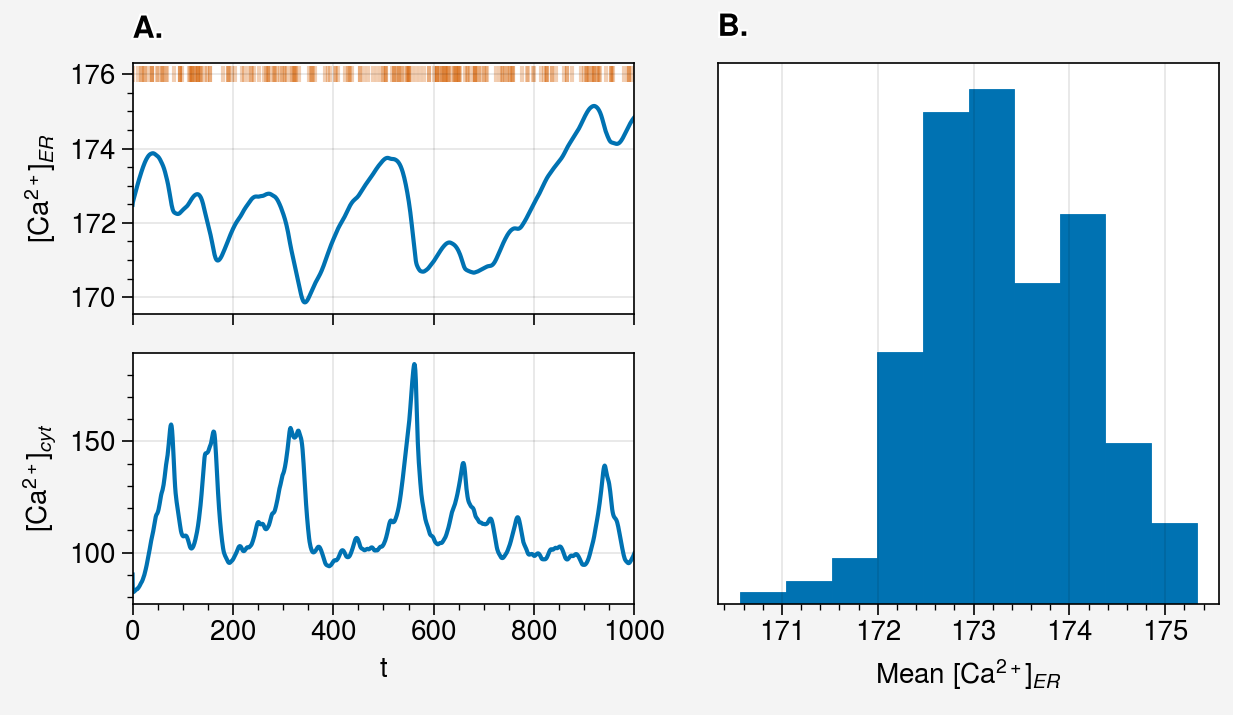

In [32]:
data = pickle.load(open('data/plot_data/oscillation_delay/poisson_stimulation_distribution', 'rb'))

array = [
    [1, 1, 3, 3],
    [2, 2, 3, 3]
]

fig, ax = pplt.subplots(array, refaspect=2, wspace=3, sharex=False, 
                        sharey=False, figwidth=7)

cfg.input_start = 0
cfg.input_duration = 0.06
cfg.input_max = 0.4
set_init('c_t')

# Plot example poisson stimulation
random.seed(1)
cfg.train = generate_train(0.2, t_f=2000)
sol = run_experiment('exponential_train', max_step=1, t_f=1000)


ax[0].plot(cfg.t, cfg.c_er)
ax[1].plot(cfg.t, cfg.c*1000)
ax[0].scatter(cfg.train, np.full(cfg.train.shape, 176), marker='|',
              alpha=0.3)

# Plot c_er distributions
ax[2].hist(data['c_ers'])

ax[:2].format(xlabel='t')
ax[0].format(xticklabels=[], ylabel=c_er_label,
            xlim=[0, 1000], xlabel='')
ax[1].format(ylabel=c_label)
ax[2].format(xlabel=r'Mean [Ca$^{2+}$]$_{ER}$', yticks=[])

add_abc_to_subaxes(ax[0], top=1.1)
add_abc_to_subaxes(ax[2], 'B.')

fig.savefig(save + '3_2_poisson_stimulations')

# Diversity plots

## Example trajectory types

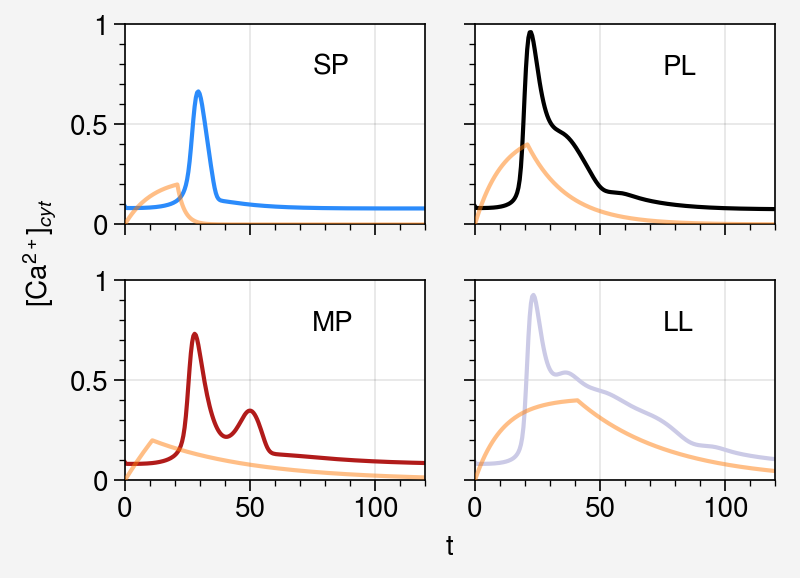

In [23]:
resp_types = ['SP', 'PL', 'MP', 'LL']
set_init('c_t')

fig, ax = pplt.subplots(ncols=2, nrows=2, refaspect=1.5, figwidth=4,
                        spanx=True, spany=True)
ox = ax.alty()

for i, typ in enumerate(resp_types):
    curve = glut_curves[typ]
    cfg.A = curve['A']
    cfg.d_decay = curve['d_decay']
    cfg.d_rise = curve['d_rise']
    cfg.r_decay = curve['r_decay']
    cfg.r_rise = curve['r_rise']
    
    sol = run_experiment('curve', t_f=120, max_step=0.5)
    ax[i].plot(cfg.t, cfg.c, c=diversity_colors[typ])
    ox[i].plot(cfg.t_input, cfg.glut, c=rgb_colors[1], alpha=0.5)
    
    ax[i].text(75, 0.75, typ)
    
ax.format(ylim=[0, 1], xlabel='t', ylabel=c_label, yticks=[0, 0.5, 1])
ox.format(ylim=[0, 5], yticks=[])

fig.savefig(save + '4_1_example_diversity_trajectories')


## Diversity confirmation

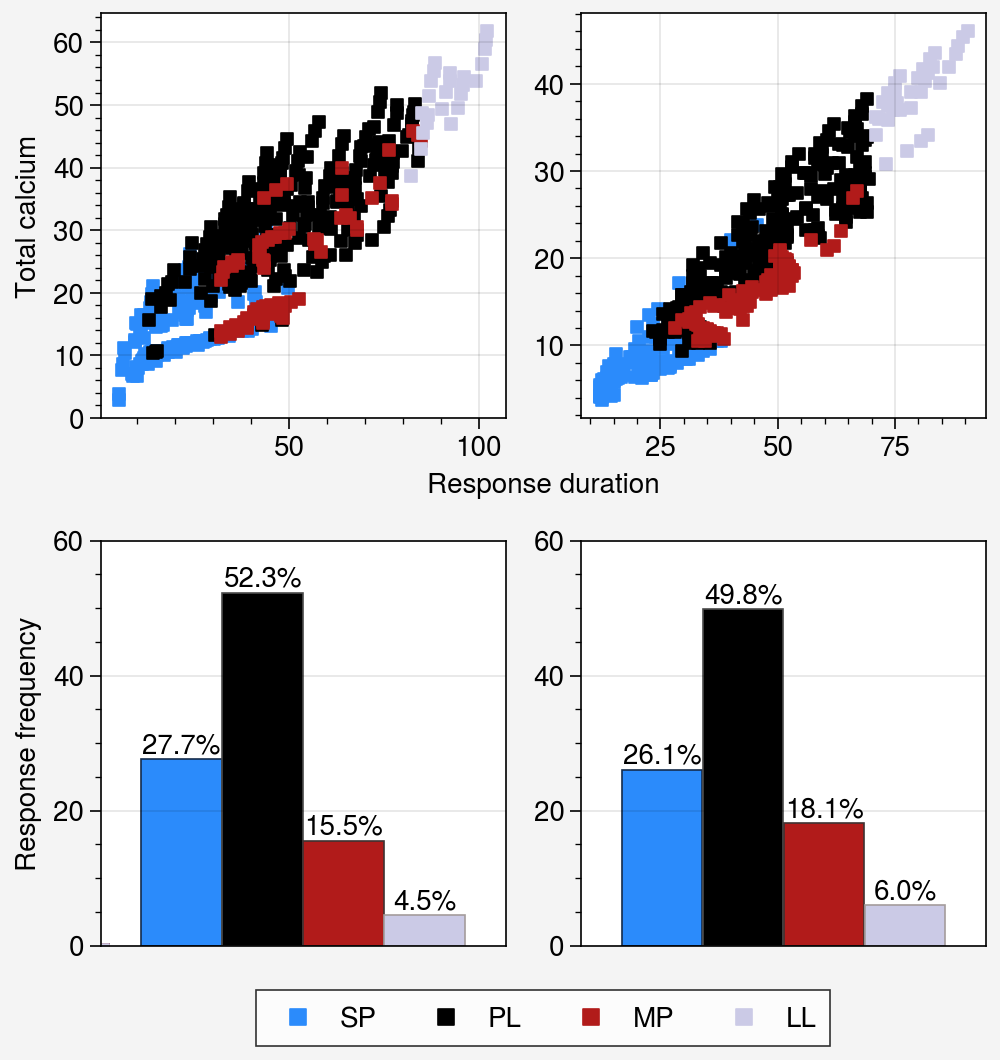

In [27]:
ip3_results = pd.read_pickle('data/ca_diversity/ip3/default')
glut_results = pd.read_pickle('data/ca_diversity/blocking/default')

fig, ax = pplt.subplots(nrows=2, ncols=2, figwidth=5, sharex=False, sharey=False,
                       spanx=True)

diversity_dotplot(ip3_results, ax=ax[0, 0], legend=False)
diversity_dotplot(glut_results, ax=ax[0, 1], legend=False)
diversity_barchart(ip3_results, ax=ax[1, 0], fontsize=10, legend=False)
diversity_barchart(glut_results, ax=ax[1, 1], fontsize=10, legend=False)

lines = []
for typ in diversity_colors:
    lines.append(ax[1, 0].scatter([-1], [-1], c=diversity_colors[typ], 
                    label=typ, marker='s'))
fig.legend(lines, ncols=4, loc='b')
    
ax[0, :].format(ylabel='', xlabel='Response duration')
ax[0, 0].format(ylabel='Total calcium')
ax[1, 0].format(ylabel='Response frequency')
fig.savefig(save + '4_2_diversity_confirmation')

## Channel Blocking

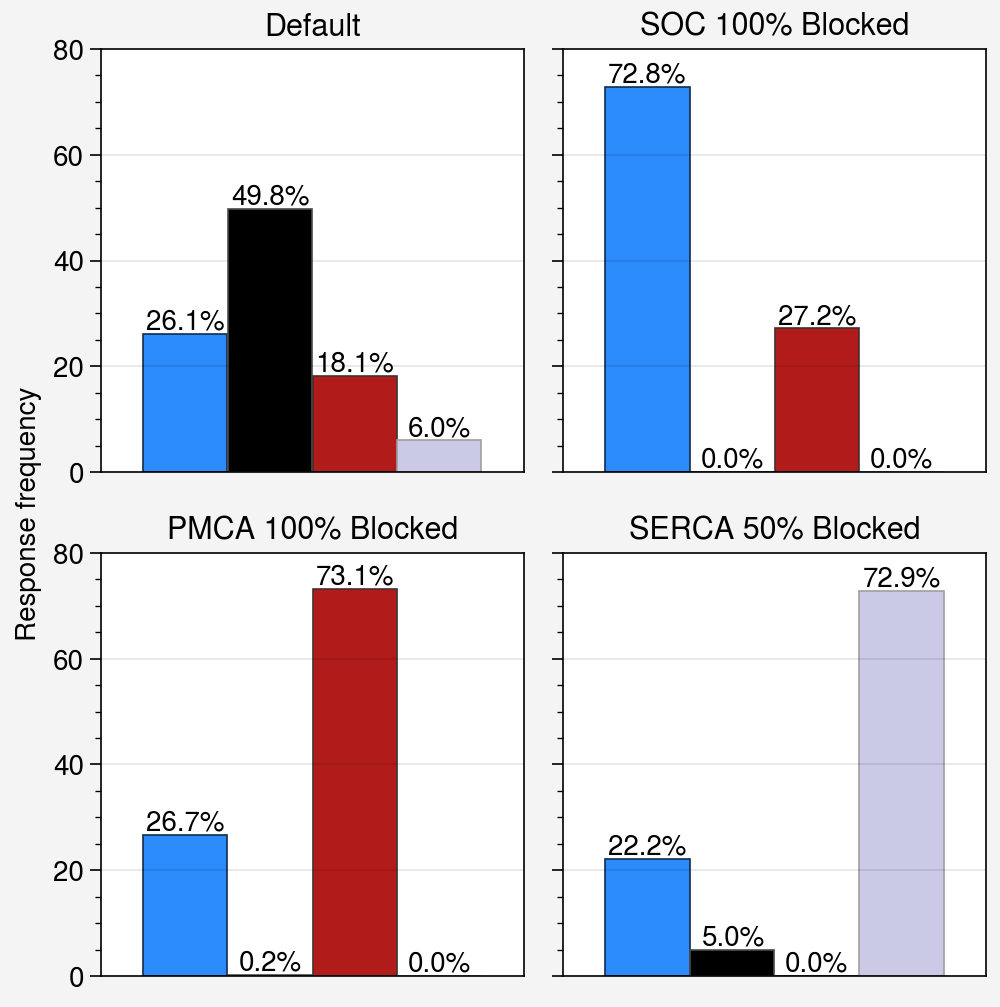

In [60]:
files = ['default', 'soc_0', 'pmca_0', 'serca_0.5']
titles = ['Default', 'SOC 100% Blocked', 'PMCA 100% Blocked', 'SERCA 50% Blocked']

folder = 'data/ca_diversity/blocking/'

fig, ax = pplt.subplots(nrows=2, ncols=2, figwidth=5, spany=True)

for i, file in enumerate(files):
    n = i % 2
    m = int(np.floor(i / 2))
    
    results = pd.read_pickle(folder + file)
    diversity_barchart(results, ax=ax[m, n], legend=False, ylim=80,
                      fontsize=10)
    
    ax[m, n].set_title(titles[i])
    
ax.format(ylabel='Response frequency')
plt.savefig(save + '4_3_diversity_channel_block', bbox_inches='tight')

## Ca2+ -> IP3 Feedbacks

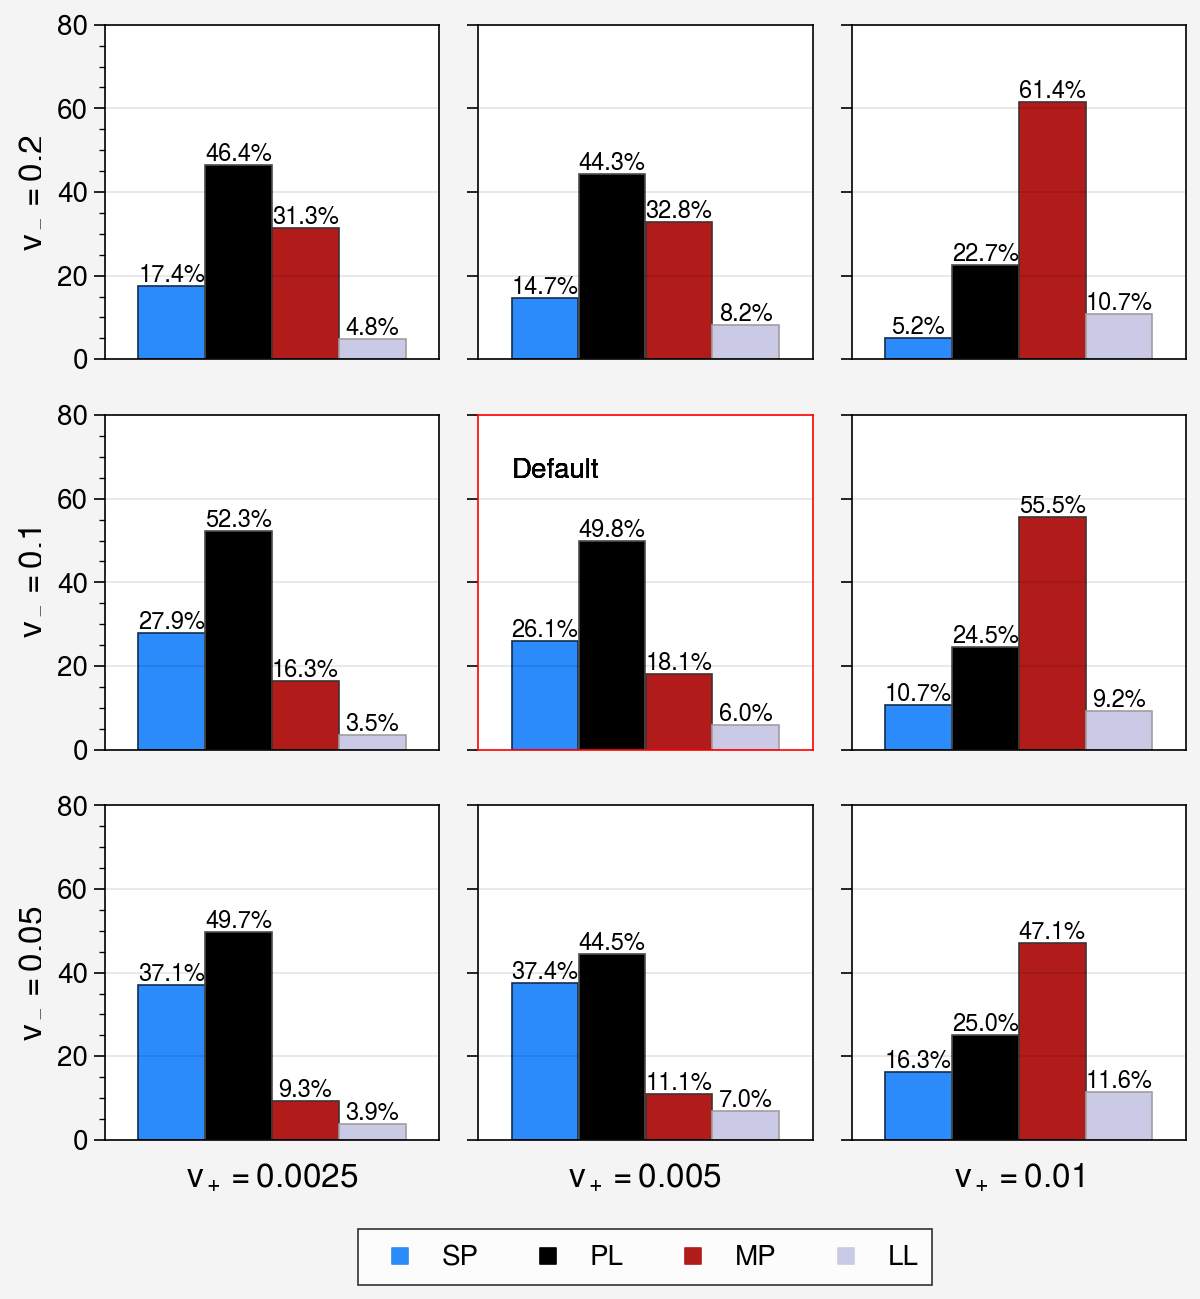

In [57]:
conditions = {
    'kd1': [0, 0.02, 0.04],
    'kd2': [0, 0.6, 1.2],
    'v_3k': [0.05, 0.1, 0.2],
    'v_delta': [0.0025, 0.005, 0.01],
}

folder = 'data/ca_diversity/calibrated/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
    'kd1': 0.02,
    'kd2': 1.2,
#     'v_3k': 0.1,
#     'v_delta': 0.005
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'kd1': 'k$_d1=',
    'kd2': 'k$_d2=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = 3
n = 3

fig, ax = pplt.subplots(nrows=m, ncols=n, figwidth=6,
                        sharex=False, sharey=False)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
        setattr(cfg, cond, conditions[cond][m-i-1])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(cfg.kd1, cfg.kd2, cfg.v_3k, cfg.v_delta)
        
        results = pd.read_pickle(folder + file)
        
        diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80, fontsize=8.5)

for i in range(m):
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(conditions[cond_types[0]][m-i-1]) + '$',
                       fontsize=12)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(conditions[cond_types[1]][j]) + '$',
                         fontsize=12)
        
spines = ['top', 'bottom', 'left', 'right']
for spine in spines:
    ax[1, 1].spines[spine].set_color('red')
    ax[1, 1].text(-0.5, 65, 'Default', size=10)
        
ax[:, 1:].format(yticklabels=[])

lines = generate_diversity_legend(ax[0, 1], -5, -5)
fig.legend(lines, loc='b', ncols=4)
fig.savefig(save + '4_4_ca_feedback_diversity')

## Gd1 Gd2

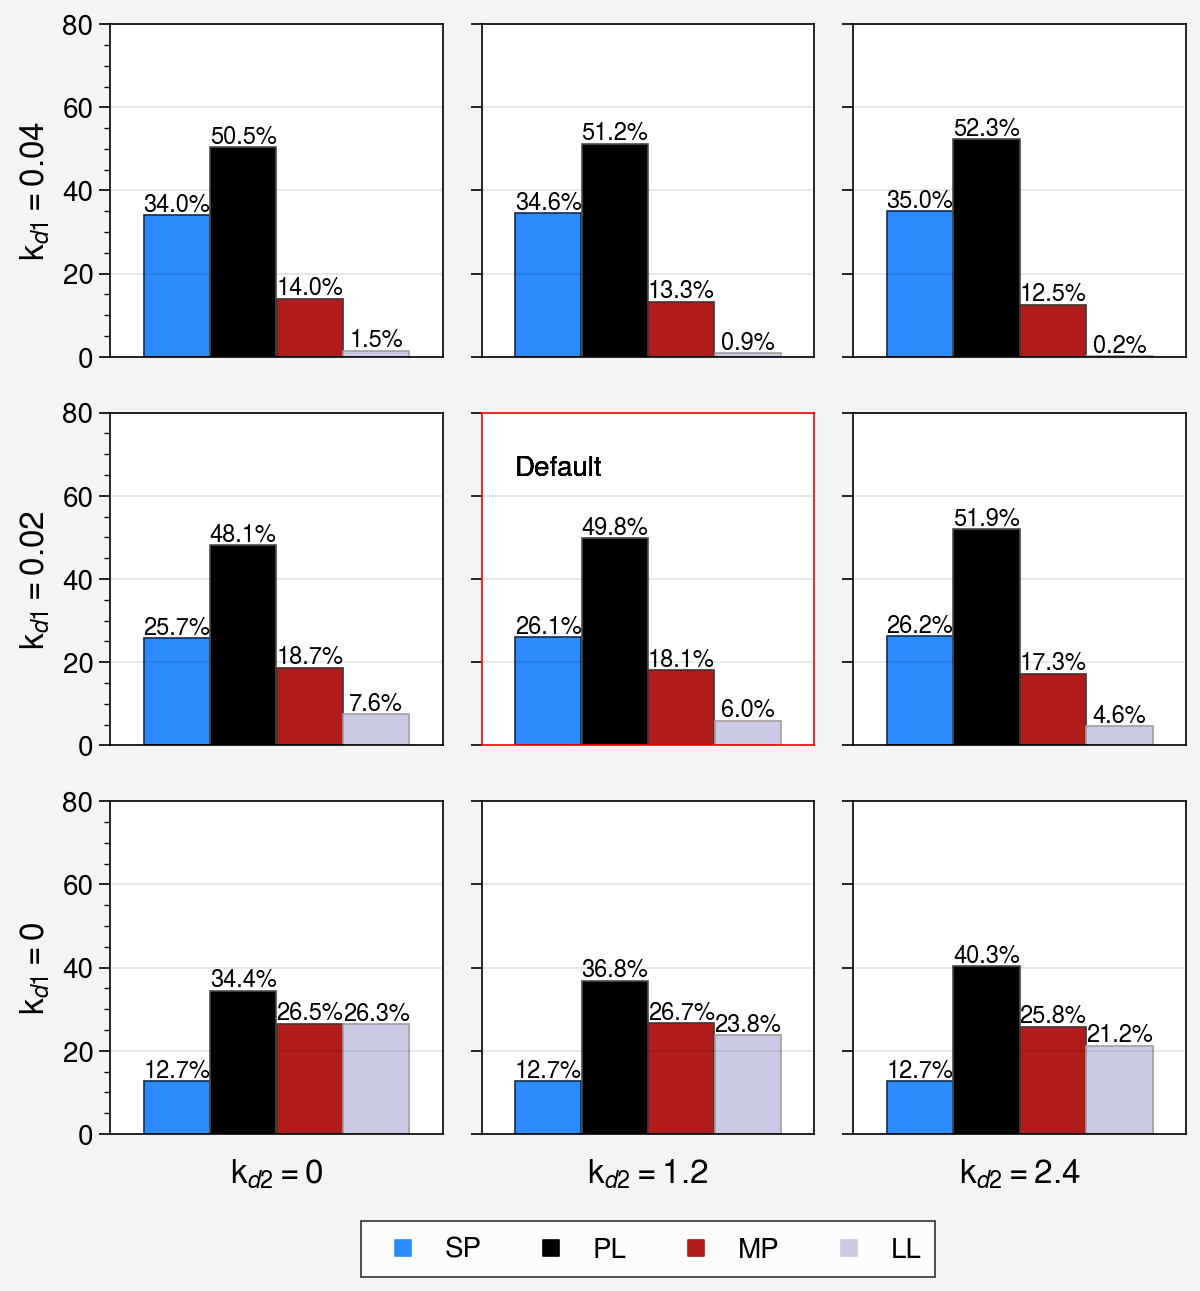

In [63]:
conditions = {
    'kd1': [0, 0.02, 0.04],
    'kd2': [0, 1.2, 2.4],
    'v_3k': [0.05, 0.1, 0.2],
    'v_delta': [0.0025, 0.005, 0.01],
}

folder = 'data/ca_diversity/calibrated/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
    # 'kd1': 0.02,
    # 'kd2': 1.2,
    'v_3k': 0.1,
    'v_delta': 0.005
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'kd1': 'k$_{d1}=',
    'kd2': 'k$_{d2}=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = 3
n = 3

fig, ax = pplt.subplots(nrows=m, ncols=n, figwidth=6,
                        sharex=False, sharey=False)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
        setattr(cfg, cond, conditions[cond][m-i-1])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(cfg.kd1, cfg.kd2, cfg.v_3k, cfg.v_delta)
        # print(file)
        results = pd.read_pickle(folder + file)
        
        diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80, fontsize=8.5)

for i in range(m):
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(conditions[cond_types[0]][m-i-1]) + '$',
                       fontsize=12)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(conditions[cond_types[1]][j]) + '$',
                         fontsize=12)
        
spines = ['top', 'bottom', 'left', 'right']
for spine in spines:
    ax[1, 1].spines[spine].set_color('red')
    ax[1, 1].text(-0.5, 65, 'Default', size=10)
        
ax[:, 1:].format(yticklabels=[])

lines = generate_diversity_legend(ax[0, 1], -5, -5)
fig.legend(lines, loc='b', ncols=4)
fig.savefig(save + '4_5_Gd_diversity')

# Spritz Experiments

## Response type heatmap

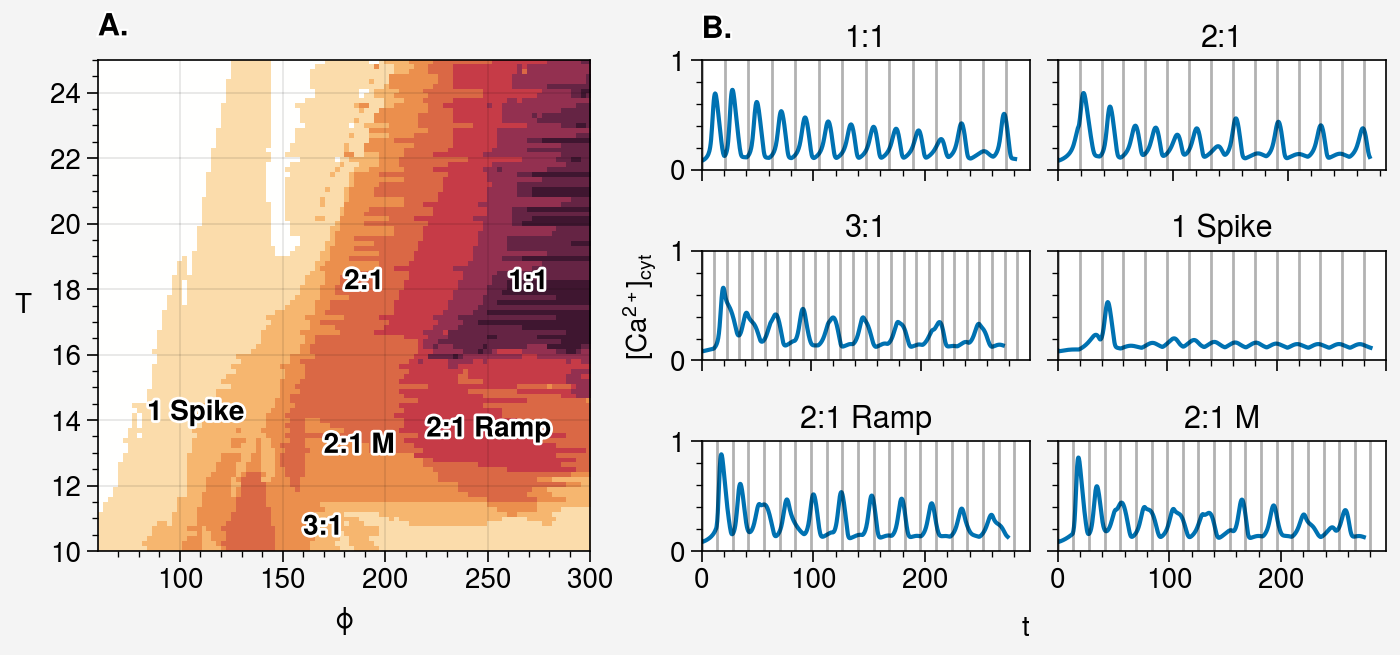

In [21]:
data = pickle.load(open('data/spritz/10_spritz_summary_compressed', 'rb'))
set_init('c_t')
periods = np.linspace(10, 25, 100)
gluts = np.linspace(60, 300, 100)

array = [[1,1,1, 2,2, 3,3],
         [1,1,1, 4,4, 5,5],
         [1,1,1, 6,6, 7,7]]

fig, ax = pplt.subplots(array, figwidth=7, sharex=False, wspace=(0,0, 4, 0, 1, 0))

'''Generate heatmap'''
hm = []
for period in periods:
    row = []
    for glut in gluts:
        key = f't{period:.1f}p{glut:.1f}'
        # c = data[key]
        t, c = data[key]
        peaks = evaluate_peaks(c=c, t=t, cutoff_peak=0.3, cutoff_trough=0.2,
                              period=period, skip_first=2)
        row.append(len(peaks))
    hm.append(row)
hm = np.flip(hm, axis=0)


c = ax[0].imshow(hm, extent=(60, 300, 10, 25), aspect='auto')

text_labels = [
    (260, 18, '1:1'),
    (180, 18, '2:1'),
    (160, 10.5, '3:1'),
    (170, 13, '2:1 M'),
    (84, 14, '1 Spike'),
    (220, 13.5, '2:1 Ramp')
]

for text in text_labels:
    txt = ax[0].text(text[0], text[1], text[2], c='black', fontweight='1000')
    txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

'''Generate spritzes'''

text_labels = [
    (320, 20, '1:1'),
    (240, 18, '2:1'),
    (160, 10.5, '3:1'),
    
    (130, 19, '1 Spike'),    
    (240, 13, '2:1 Ramp'),
    (220, 13, '2:1 M'),
]

for i, text in enumerate(text_labels):
    glut = text[0]
    per = text[1]
    title = text[2]
    
    plot_spritz(glut, per, ax[i+1], max_t=300, dur=0.05)
    ax[i+1].format(title=title)

ax[1:5].format(xticklabels=[], xlabel='')
ax[1:].format(ylim=[0, 1], yticks=[0, 1], xgrid=False)
fig.text(0.73, 0.03, 't')
ax[3].format(ylabel=c_label)
ax[0].format(xlabel='$\phi$')
ax[0].set_ylabel('T', rotation=0, labelpad=10, va='center')

add_abc_to_subaxes(ax[0])
add_abc_to_subaxes(ax[1], 'B.', top=1.2)

fig.savefig(save + '5_1_spritz_responses')

# Glutamate G* Relation

c:\Users\14and\Desktop\Work\github\epilepsy_astrocytes2\Python\ip3_ca_ode_cfg.py:248: RuntimeWarning: invalid value encountered in scalar power
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
c:\Users\14and\Desktop\Work\github\epilepsy_astrocytes2\Python\ip3_ca_ode_cfg.py:248: RuntimeWarning: invalid value encountered in scalar power
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)


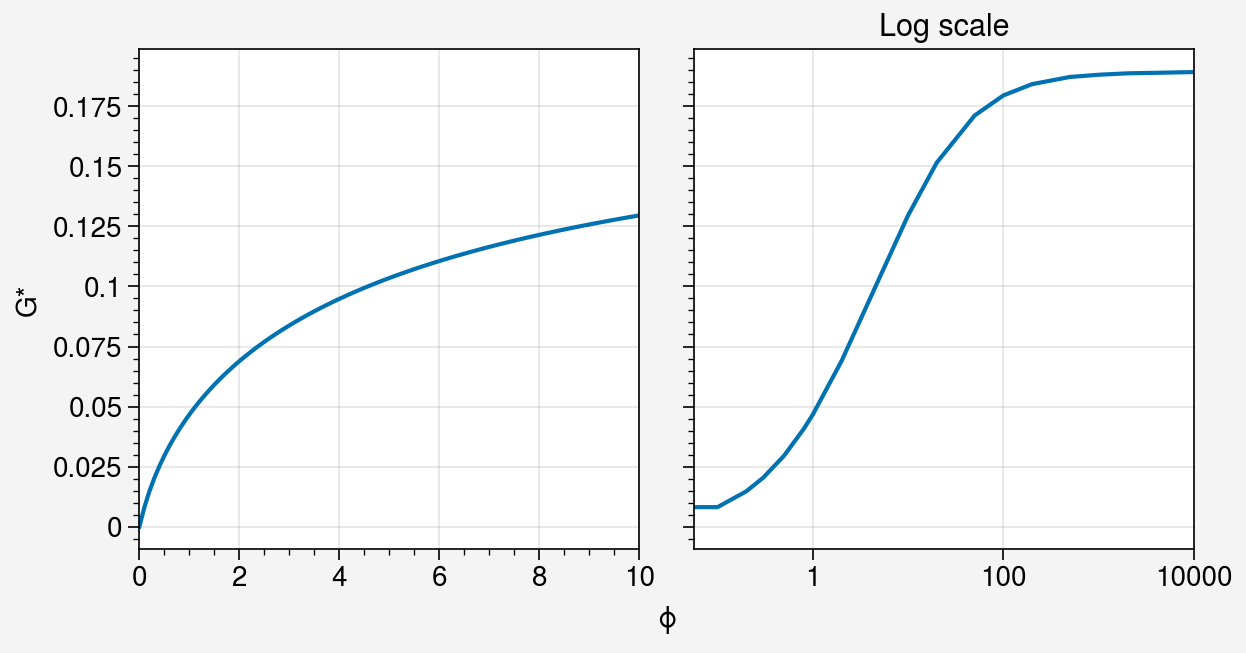

In [44]:
fig, ax = pplt.subplots(ncols=2)

glut_sizes = np.linspace(0, 10, 100)
Gstars = []
for glut in glut_sizes:
    cfg.input_max = glut
    cfg.input_duration = 5000
    run_experiment('pulse', max_step=100)
    Gstars.append(cfg.Gstar[-1])
ax[0].plot(glut_sizes, Gstars)
glut_sizes = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

Gstars = []
for glut in glut_sizes:
    cfg.input_max = glut
    cfg.input_duration = 5000
    run_experiment('pulse', max_step=100)
    Gstars.append(cfg.Gstar[-1])    
ax[1].plot(glut_sizes, Gstars)
ax[1].format(xscale='log', title='Log scale')

ax.format(xlabel=r'$\phi$', ylabel='G*')